In [ ]:
import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta
import numpy as np 
import pandas as pd 
import tweepy 
import json
import nltk

In [ ]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [ ]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [ ]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'Authorization': 'Bearer (Bearer Token)'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex -is:retweet) (lang:en)', # 
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [ ]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [ ]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-12-01T07:36:58Z'

In [ ]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)


In [ ]:
auth.set_access_token(access_token, access_secret)


In [ ]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [ ]:
last_20_tweets_of_ElonMusk = api.user_timeline('elonmusk')



In [ ]:
my_list_of_dicts = []
for each_json_tweet in last_20_tweets_of_ElonMusk:
    my_list_of_dicts.append(each_json_tweet._json)

In [ ]:
with open('tweet_json_Elon.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [ ]:
my_demo_list = []
with open('tweet_json_Elon.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        my_demo_list.append({'tweet_id': str(tweet_id),
                             'text': str(text),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'created_at': created_at,
                            })
        #print(my_demo_list)
        tweet_json = pd.DataFrame(my_demo_list, columns = 
                                  ['tweet_id', 'text', 
                                   'favorite_count', 'retweet_count', 
                                   'created_at'])

In [ ]:
api = tweepy.API(auth)

results = api.search(q='cheese', count=100)

json_data = [r._json for r in results]

df = pd.json_normalize(json_data)

In [ ]:
df

,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,entities.hashtags,entities.symbols,entities.user_mentions,entities.urls,entities.media,extended_entities.media,metadata.result_type,metadata.iso_language_code,user.id,user.id_str,user.name,user.screen_name,user.location,user.description,user.url,user.entities.description.urls,user.protected,user.followers_count,...,retweeted_status.quoted_status.user.profile_image_url,retweeted_status.quoted_status.user.profile_image_url_https,retweeted_status.quoted_status.user.profile_banner_url,retweeted_status.quoted_status.user.profile_link_color,retweeted_status.quoted_status.user.profile_sidebar_border_color,retweeted_status.quoted_status.user.profile_sidebar_fill_color,retweeted_status.quoted_status.user.profile_text_color,retweeted_status.quoted_status.user.profile_use_background_image,retweeted_status.quoted_status.user.has_extended_profile,retweeted_status.quoted_status.user.default_profile,retweeted_status.quoted_status.user.default_profile_image,retweeted_status.quoted_status.user.following,retweeted_status.quoted_status.user.follow_request_sent,retweeted_status.quoted_status.user.notifications,retweeted_status.quoted_status.user.translator_type,retweeted_status.quoted_status.user.withheld_in_countries,retweeted_status.quoted_status.geo,retweeted_status.quoted_status.coordinates,retweeted_status.quoted_status.place,retweeted_status.quoted_status.contributors,retweeted_status.quoted_status.is_quote_status,retweeted_status.quoted_status.quoted_status_id,retweeted_status.quoted_status.quoted_status_id_str,retweeted_status.quoted_status.retweet_count,retweeted_status.quoted_status.favorite_count,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.lang,retweeted_status.quoted_status.user.entities.url.urls,place.id,place.url,place.place_type,place.name,place.full_name,place.country_code,place.country,place.contained_within,place.bounding_box.type,place.bounding_box.coordinates
0,Wed Dec 01 07:36:56 +0000 2021,1465948011305914368,1465948011305914368,RT @hee_bebe__: 희승이 빨머셀카 쭈아!ㅎ https://t.co/LH7...,False,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,None,None,NaN,None,False,18,0,False,False,False,ko,[],[],"[{'screen_name': 'hee_bebe__', 'name': '희깅', '...",[],"[{'id': 1465940388729204736, 'id_str': '146594...","[{'id': 1465940388729204736, 'id_str': '146594...",recent,ko,1307912511824343040,1307912511824343040,치즈,CHEESE__1015,,,None,[],False,4103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Dec 01 07:36:54 +0000 2021,1465948002938277888,1465948002938277888,RT @YoonJoo25602712: 괴도가 애기들 위해서 깜짝 크리스마스 파티를 ...,False,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,None,None,NaN,None,False,51,0,False,False,False,ko,[],[],"[{'screen_name': 'YoonJoo25602712', 'name': '💎...",[],"[{'id': 1465651686505345026, 'id_str': '146565...","[{'id': 1465651686505345026, 'id_str': '146565...",recent,ko,1368185378117537792,1368185378117537792,웃음빌런 김블즈,blue_cheese_bz,,이상한거 많이 들고오는 잡덕계.들여오는거 불편하시면 블락해주세요/내 그림을 훔쳐가는...,https://t.co/VLFTNnHpeC,[],False,321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Dec 01 07:36:54 +0000 2021,1465948002342748162,1465948002342748162,"@DregsFrolics @JeffreyLuscombe What, you mean ...",False,"<a href=""http://twitter.com/#!/download/ipad"" ...",1.465935e+18,1465935108288880640,50085704.0,50085704,DregsFrolics,None,None,NaN,None,False,0,0,Fa

In [ ]:
df.shape

(100, 238)

In [ ]:
df.to_csv("TwitterData_latest_elonmusk.csv")


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 15.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
user_elonmusk = api.get_user(screen_name='elonmusk')


In [ ]:
print(user_elonmusk.screen_name)
print(user_elonmusk.followers_count)


elonmusk
65159584


In [ ]:
import yfinance as yf 

tsla = yf.Ticker("TSLA")
print(tsla)

yfinance.Ticker object <TSLA>


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=0 and row['retweet_count']>=0 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-12-01T07:31:57.000Z,1465946758463332352,0.0,0.0,77664.0,RT @cz_binance: I'm giving away a DOGE Tesla &...
1,2021-12-01T07:31:56.000Z,1465946752708661250,0.0,0.0,5490.0,"RT @binance: Win a custom $DOGE Tesla or $50,0..."
2,2021-12-01T07:31:56.000Z,1465946751265763328,0.0,0.0,6004.0,RT @VGrtoken: followed by the logo and list of...
3,2021-12-01T07:31:50.000Z,1465946726200602629,0.0,0.0,0.0,@SAFEDRIVE19 @Dudefromwsb @elonmusk @saylor @T...
4,2021-12-01T07:31:47.000Z,1465946713856917513,0.0,0.0,77664.0,RT @cz_binance: I'm giving away a DOGE Tesla &...
...,...,...,...,...,...,...
168854,2021-11-25T07:37:16.000Z,1463773766866010115,2.0,2.0,0.0,Tesla’s are wild bro
168855,2021-11-25T07:37:08.000Z,1463773734846681091,0.0,0.0,452.0,RT @CryptoLadyx: 🎅Micro Santa🎅\n\n✅8% BUSD Rew...
168856,2021-11-25T07:37:08.000Z,1463773734637129735,0.0,0.0,36.0,RT @business: Elon Musk has offloaded 9.2 mill...
168857,2021-11-25T07:37:01.000Z,1463773705335709696,0.0,0.0,53.0,RT @Matthew_Teudor: The current 22KW units are...


In [ ]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

#import flair #lstm model
#sentiment_model = flair.models.TextClassifier.load('en-sentiment')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def is_positive(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(tweet)["compound"] > 0

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    if is_positive(tweet): binary.append(1)
    else: binary.append(0)
    #sentence = flair.data.Sentence(tweet)
    #sentiment_model.predict(sentence)
    # extract sentiment prediction
    #sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    #if sentence.labels[0].value == 'NEGATIVE':
    #    probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
    #    binary.append(0)
    #else:
    #    probs.append(sentence.labels[0].score)  # numerical score 0-1
     #   binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
#df['probability'] = probs
#df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,binary,Date
0,2021-12-01T07:31:57.000Z,1465946758463332352,0.0,0.0,77664.0,RT @cz_binance: I'm giving away a DOGE Tesla &...,"RT : I'm giving away a DOGE Tesla &amp; $50,00...",1,2021-12-01
1,2021-12-01T07:31:56.000Z,1465946752708661250,0.0,0.0,5490.0,"RT @binance: Win a custom $DOGE Tesla or $50,0...","RT : Win a custom $DOGE Tesla or $50,000 in $D...",1,2021-12-01
2,2021-12-01T07:31:56.000Z,1465946751265763328,0.0,0.0,6004.0,RT @VGrtoken: followed by the logo and list of...,RT : followed by the logo and list of VGr on C...,0,2021-12-01
3,2021-12-01T07:31:50.000Z,1465946726200602629,0.0,0.0,0.0,@SAFEDRIVE19 @Dudefromwsb @elonmusk @saylor @T...,Tesla Thank you for the opportunity. I ...,1,2021-12-01
4,2021-12-01T07:31:47.000Z,1465946713856917513,0.0,0.0,77664.0,RT @cz_binance: I'm giving away a DOGE Tesla &...,"RT : I'm giving away a DOGE Tesla &amp; $50,00...",1,2021-12-01
...,...,...,...,...,...,...,...,...,...
168854,2021-11-25T07:37:16.000Z,1463773766866010115,2.0,2.0,0.0,Tesla’s are wild bro,Tesla’s are wild bro,0,2021-11-25
168855,2021-11-25T07:37:08.000Z,1463773734846681091,0.0,0.0,452.0,RT @CryptoLadyx: 🎅Micro Santa🎅\n\n✅8% BUSD Rew...,RT : 🎅Micro Santa🎅 ✅8% BUSD Rewards ✅3% Buy-Ba...,1,2021-11-25
168856,2021-11-25T07:37:08.000Z,1463773734637129735,0.0,0.0,36.0,RT @business: Elon Musk has offloaded 9.2 mill...,RT : Elon Musk has offloaded 9.2 million share...,1,2021-11-25
168857,2021-11-25T07:37:01.000Z,1463773705335709696,0.0,0.0,53.0,RT @Matthew_Teudor: The current 22KW units are...,RT : The current 22KW units are the worst char...,0,2021-11-25


In [ ]:

#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

#tsla = yf.Ticker("TSLA")
tsla = yf.download( "TSLA",
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d' #'60m'
        )#.reset_index()
tsla_stock = tsla.pct_change().reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) #  %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-26,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-29,0.001383,0.030565,0.017752,0.050900,0.050900,0.666353
2,2021-11-30,0.039401,0.022167,0.016188,0.006834,0.006834,0.387007


In [ ]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,binary
0,2021-11-25,4.504127,0.409947,894.861503,0.535312
1,2021-11-26,4.373086,0.454477,1191.217907,0.440821
2,2021-11-27,4.118099,0.396585,745.124070,0.424765
3,2021-11-28,5.811048,0.576398,680.385329,0.498107
4,2021-11-29,2.726695,0.283619,19397.634986,0.681648
5,2021-11-30,1.906791,0.241424,15821.557059,0.589799
6,2021-12-01,0.715449,0.071196,6785.476268,0.592369


In [ ]:
means['Date']


0    2021-11-25
1    2021-11-26
2    2021-11-27
3    2021-11-28
4    2021-11-29
5    2021-11-30
6    2021-12-01
Name: Date, dtype: object

In [ ]:
tsla_stock['Date']

0    2021-11-26
1    2021-11-29
2    2021-11-30
Name: Date, dtype: object

In [ ]:
#df['Date']=df['Date'].astype(object)


In [ ]:
combined = means.merge(tsla_stock, how='inner')
combined


,Date,like_count,reply_count,retweet_count,binary,Open,High,Low,Close,Adj Close,Volume
0,2021-11-26,4.373086,0.454477,1191.217907,0.440821,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-29,2.726695,0.283619,19397.634986,0.681648,0.001383,0.030565,0.017752,0.050900,0.050900,0.666353
2,2021-11-30,1.906791,0.241424,15821.557059,0.589799,0.039401,0.022167,0.016188,0.006834,0.006834,0.387007


In [ ]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.9999999999999999

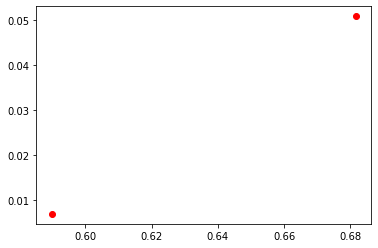

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [ ]:
tweets_file_path = 'TwitterData_latest_elonmusk.csv'

In [ ]:
tweets_data = pd.read_csv(tweets_file_path)

In [ ]:
tweets_data.describe

<bound method NDFrame.describe of     Unnamed: 0  ... place.bounding_box.coordinates
0            0  ...                            NaN
1            1  ...                            NaN
2            2  ...                            NaN
3            3  ...                            NaN
4            4  ...                            NaN
..         ...  ...                            ...
95          95  ...                            NaN
96          96  ...                            NaN
97          97  ...                            NaN
98          98  ...                            NaN
99          99  ...                            NaN

[100 rows x 239 columns]>

In [ ]:
tweets_data.columns

Index(['Unnamed: 0', 'created_at', 'id', 'id_str', 'text', 'truncated',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id',
       ...
       'place.id', 'place.url', 'place.place_type', 'place.name',
       'place.full_name', 'place.country_code', 'place.country',
       'place.contained_within', 'place.bounding_box.type',
       'place.bounding_box.coordinates'],
      dtype='object', length=239)

In [ ]:
tweets_data.shape

(100, 239)

In [ ]:
tweets_data.isnull().sum()

Unnamed: 0                         0
created_at                         0
id                                 0
id_str                             0
text                               0
                                  ..
place.country_code                98
place.country                     98
place.contained_within            98
place.bounding_box.type           98
place.bounding_box.coordinates    98
Length: 239, dtype: int64

In [ ]:
tweets_data = tweets_data = tweets_data.dropna(axis=0)

In [ ]:
# label encoding
tweets_data.replace({"Tweets":{'YES':0,'NO':1}},inplace=True)
# printing the first 5 rows of the dataframe
tweets_data.head(5)

,Unnamed: 0,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,entities.hashtags,entities.symbols,entities.user_mentions,entities.urls,entities.media,extended_entities.media,metadata.result_type,metadata.iso_language_code,user.id,user.id_str,user.name,user.screen_name,user.location,user.description,user.url,user.entities.description.urls,user.protected,...,retweeted_status.quoted_status.user.profile_image_url,retweeted_status.quoted_status.user.profile_image_url_https,retweeted_status.quoted_status.user.profile_banner_url,retweeted_status.quoted_status.user.profile_link_color,retweeted_status.quoted_status.user.profile_sidebar_border_color,retweeted_status.quoted_status.user.profile_sidebar_fill_color,retweeted_status.quoted_status.user.profile_text_color,retweeted_status.quoted_status.user.profile_use_background_image,retweeted_status.quoted_status.user.has_extended_profile,retweeted_status.quoted_status.user.default_profile,retweeted_status.quoted_status.user.default_profile_image,retweeted_status.quoted_status.user.following,retweeted_status.quoted_status.user.follow_request_sent,retweeted_status.quoted_status.user.notifications,retweeted_status.quoted_status.user.translator_type,retweeted_status.quoted_status.user.withheld_in_countries,retweeted_status.quoted_status.geo,retweeted_status.quoted_status.coordinates,retweeted_status.quoted_status.place,retweeted_status.quoted_status.contributors,retweeted_status.quoted_status.is_quote_status,retweeted_status.quoted_status.quoted_status_id,retweeted_status.quoted_status.quoted_status_id_str,retweeted_status.quoted_status.retweet_count,retweeted_status.quoted_status.favorite_count,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.lang,retweeted_status.quoted_status.user.entities.url.urls,place.id,place.url,place.place_type,place.name,place.full_name,place.country_code,place.country,place.contained_within,place.bounding_box.type,place.bounding_box.coordinates


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


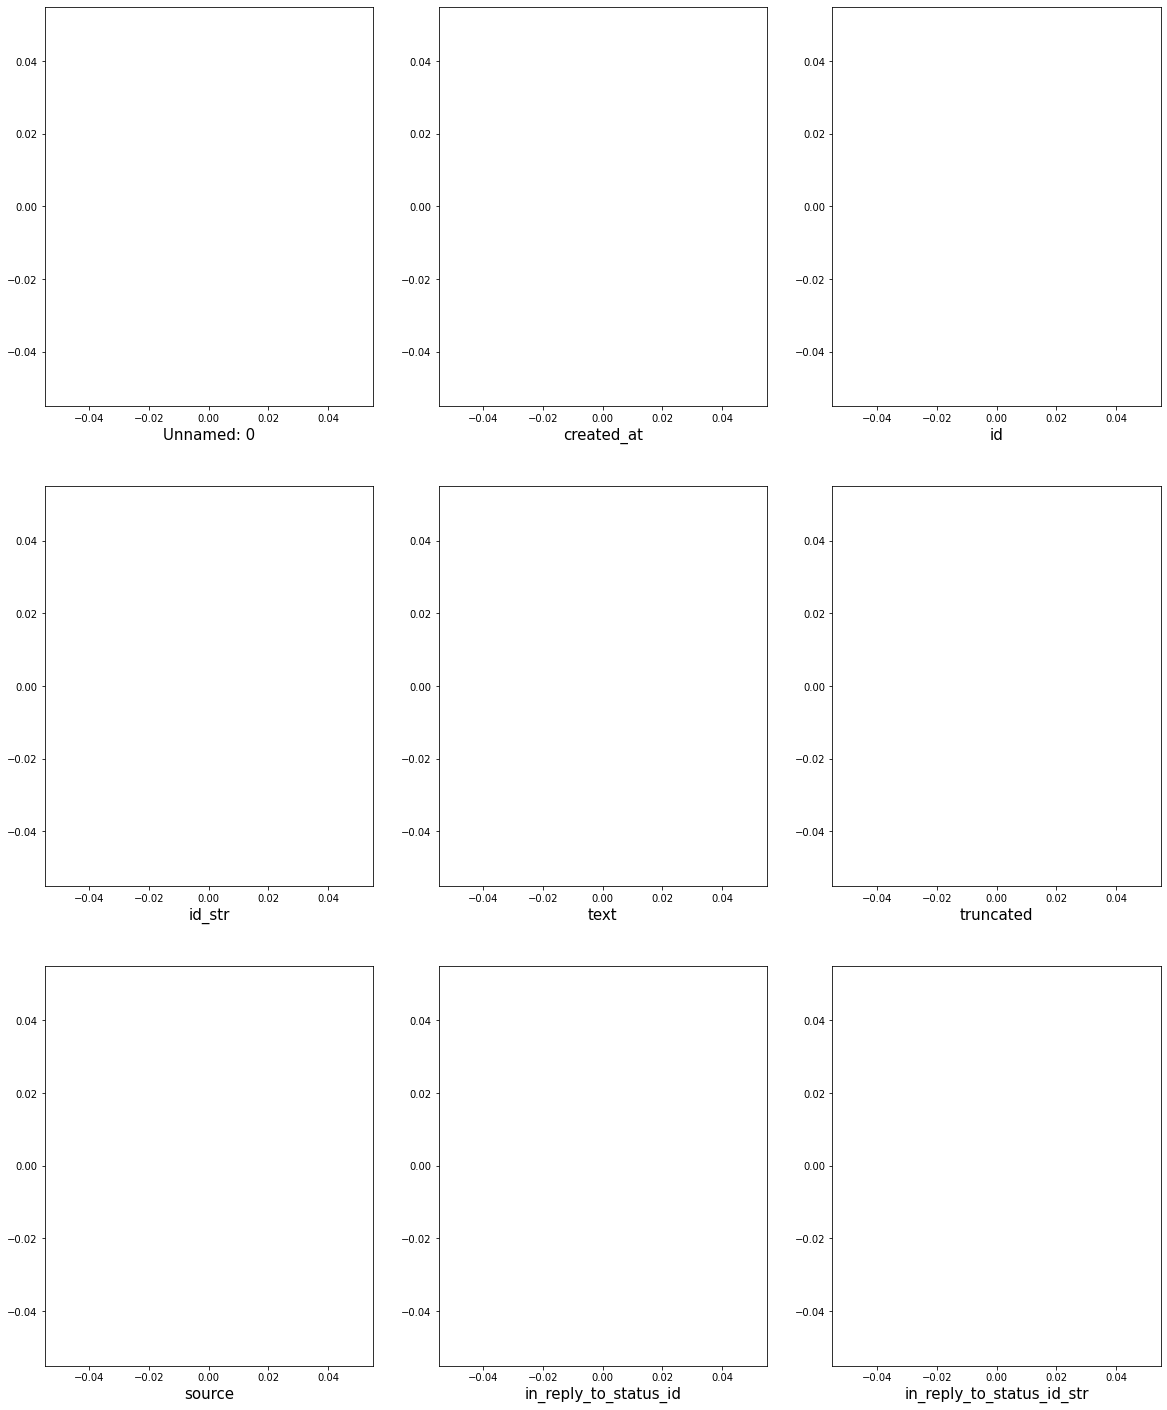

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20, 25))
plotnumber = 1
for column in tweets_data:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(tweets_data[column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
plt.show()

In [ ]:
tweets_datafeatures = ['created_at', 'text', 'geo']

In [ ]:
X = tweets_data[tweets_datafeatures]

In [ ]:
X.describe

<bound method NDFrame.describe of Empty DataFrame
Columns: [created_at, text, geo]
Index: []>

In [ ]:
X.head

<bound method NDFrame.head of Empty DataFrame
Columns: [created_at, text, geo]
Index: []>

In [ ]:
from sklearn.tree import DecisionTreeRegressor


In [ ]:
tweets_model = DecisionTreeRegressor(random_state = 1)

In [ ]:
y = tweets_data.in_reply_to_status_id

In [ ]:
tsla = yf.Ticker("TSLA")

In [ ]:
h = tsla.history()

In [ ]:
tsla.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-11-01,1145.000000,1209.750000,1118.660034,1208.589966,56048700,0,0
2021-11-02,1159.359985,1208.589966,1146.000000,1172.000000,42737800,0,0
2021-11-03,1177.329956,1215.390015,1152.619995,1213.859985,34628500,0,0
2021-11-04,1234.410034,1243.489990,1217.000000,1229.910034,25397400,0,0
2021-11-05,1228.000000,1239.869995,1208.000000,1222.089966,21579900,0,0
2021-11-08,1149.790039,1197.000000,1133.000000,1162.939941,33445700,0,0
2021-11-09,1173.599976,1174.500000,1011.520020,1023.500000,59105800,0,0
2021-11-10,1010.409973,1078.099976,987.309998,1067.949951,42802700,0,0
2021-11-11,1102.770020,1104.969971,1054.680054,1063.510010,22396600,0,0


In [ ]:
Y = tsla_history_features = ["High"]

In [ ]:
X.shape

(0, 3)

In [ ]:
#Y.shape

AttributeError: ignored

In [ ]:
tweets_model.fit(X,Y)